In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product


Populating the interactive namespace from numpy and matplotlib


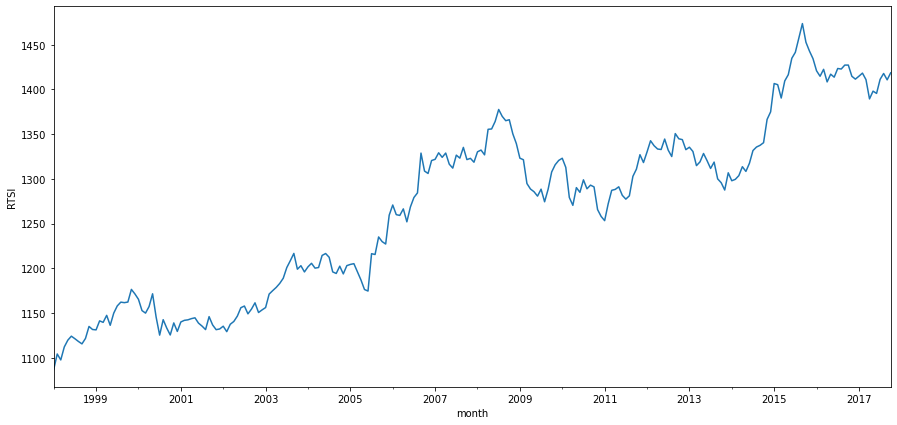

In [2]:
df = pd.read_csv('C:/Users/user/Desktop/VASYA41.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
df.id.plot()
plt.ylabel('RTSI')
pylab.show()

Критерий Дики-Фуллера: p=0.675621


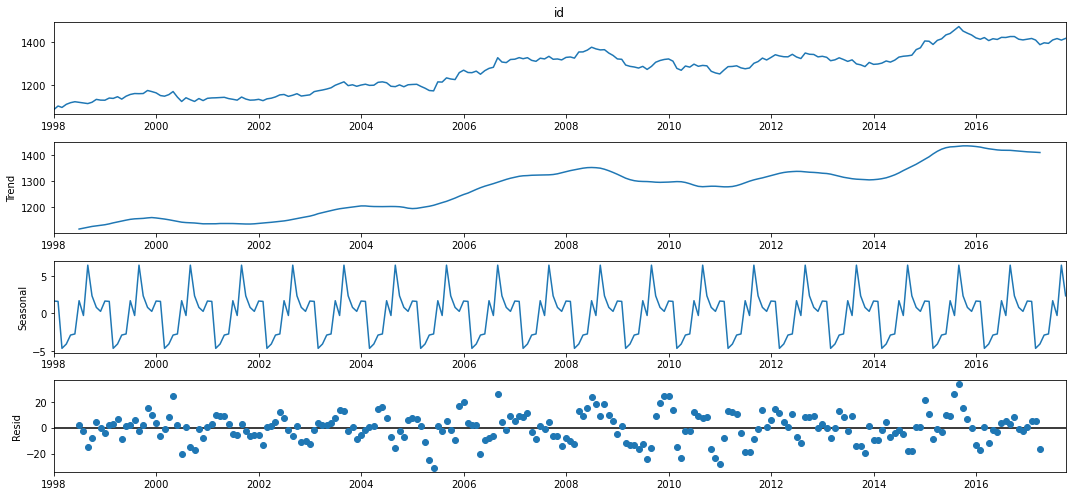

In [3]:

sm.tsa.seasonal_decompose(df.id,period=12).plot()
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.id)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.719141
Критерий Дики-Фуллера: p=0.658577


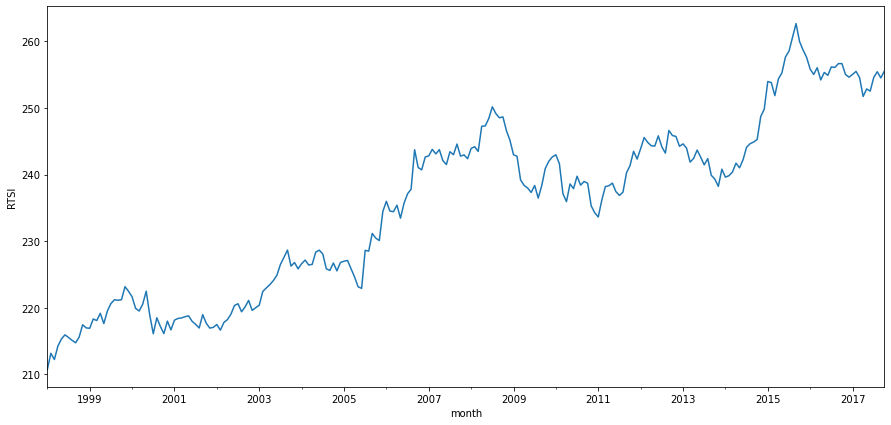

In [4]:
df['sales_box'], lmbda = stats.boxcox(pd.to_numeric(df.id))
plt.figure(figsize(15,7))
df.sales_box.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box)[1])

Критерий Дики-Фуллера: p=0.042162


<Figure size 1080x720 with 0 Axes>

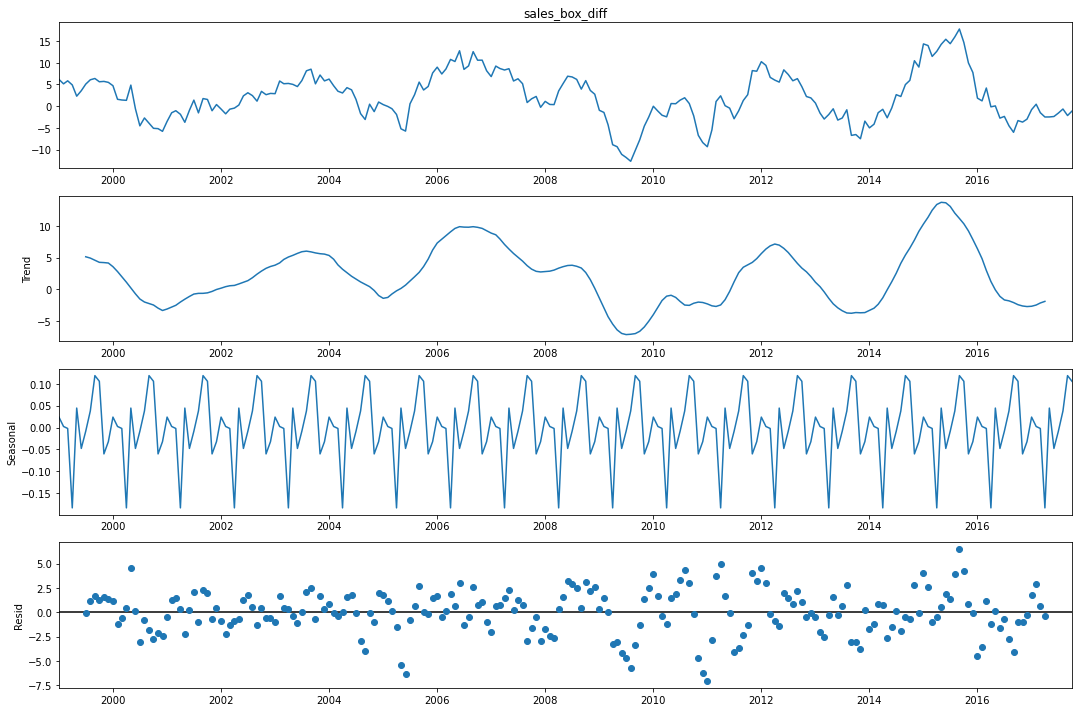

In [5]:
df['sales_box_diff'] = df.sales_box - df.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

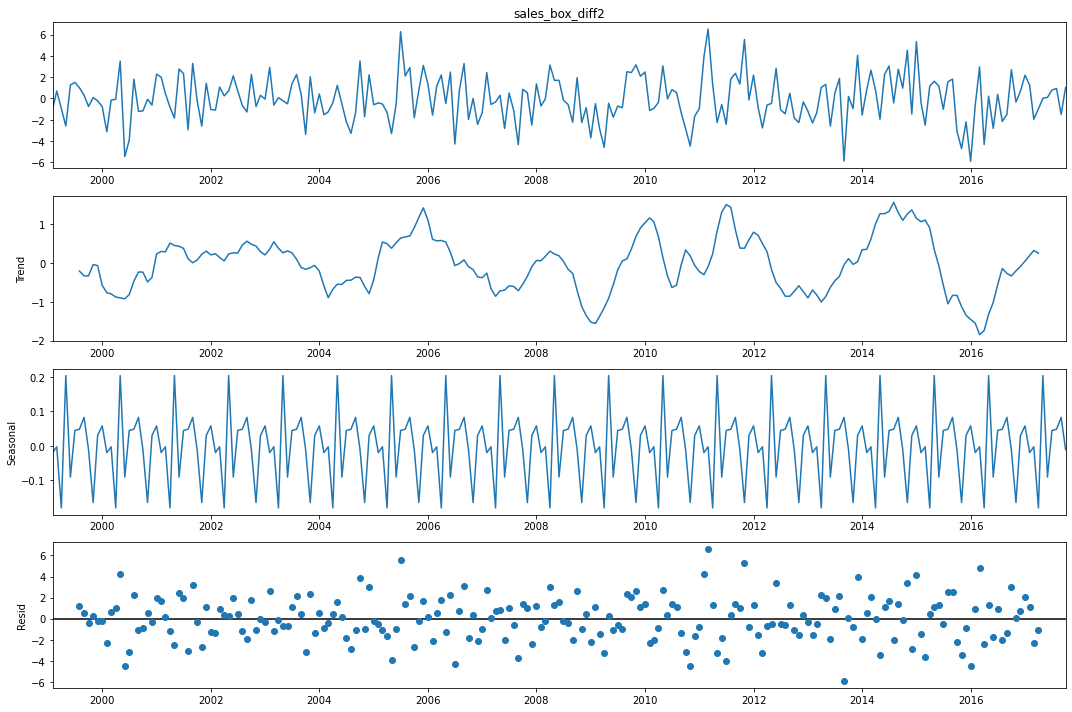

In [6]:
df['sales_box_diff2'] = df.sales_box_diff - df.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff2[13:],period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff2[13:])[1])

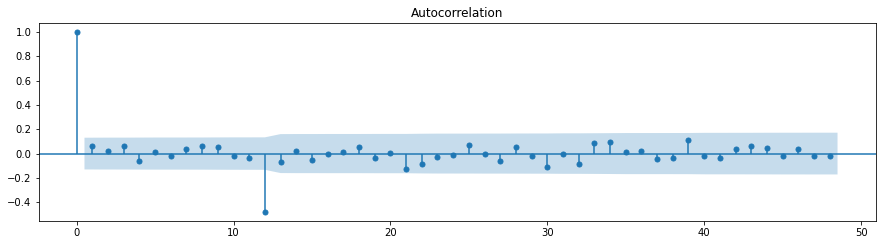

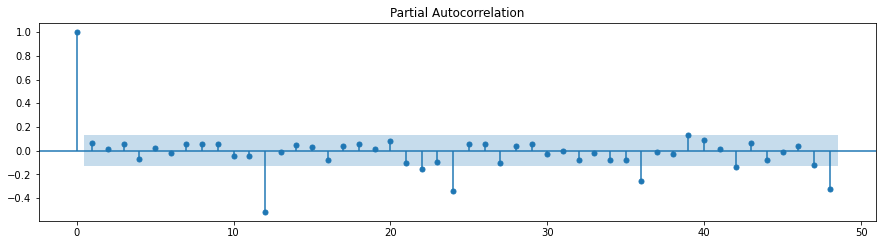

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [8]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 7s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
1   (0, 0, 0, 1)  867.074099
21  (1, 2, 0, 1)  868.242045
3   (0, 0, 1, 1)  869.044528
5   (0, 1, 0, 1)  869.071072
13  (1, 0, 0, 1)  869.071074


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            sales_box   No. Observations:                  238
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -431.537
Date:                              Mon, 12 Apr 2021   AIC                            867.074
Time:                                      10:17:09   BIC                            873.906
Sample:                                  01-01-1998   HQIC                           869.832
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9985      3.772     -0.265      0.791      -8.392       6.395
sigma2         2.31

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.544670
Критерий Дики-Фуллера: p=0.000000


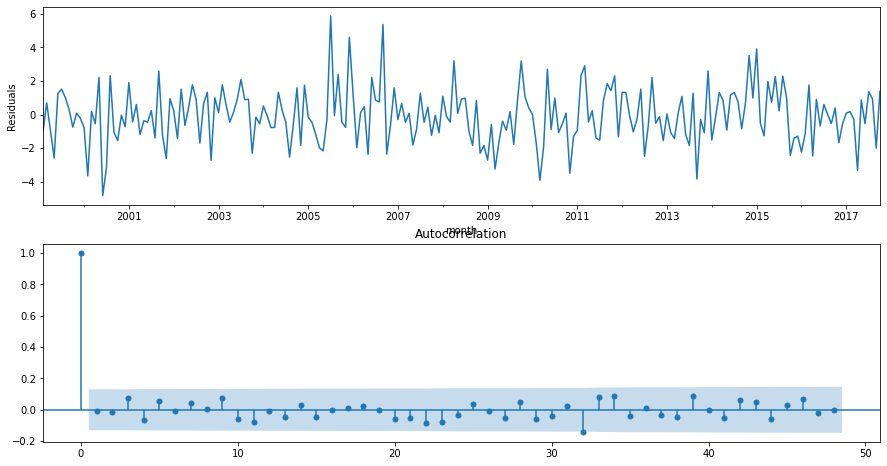

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


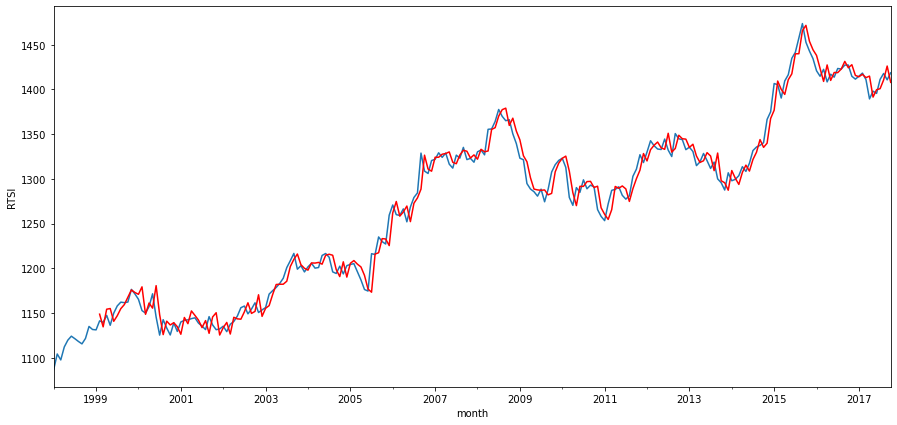

In [14]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.id.plot()
df.model[13:].plot(color='r')
plt.ylabel('RTSI')
pylab.show()

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


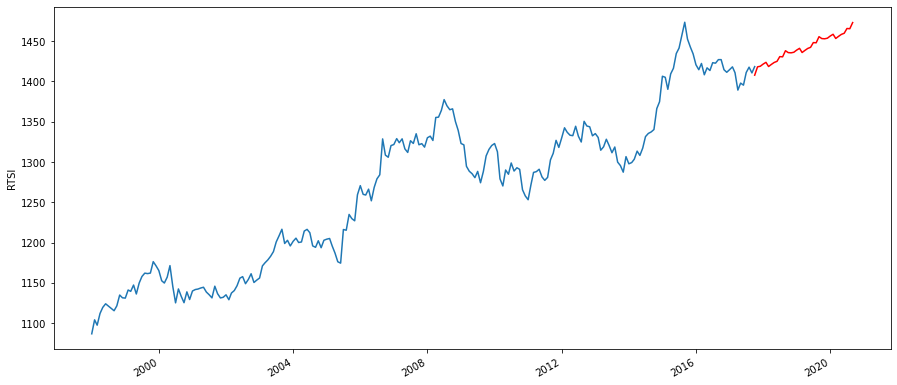

In [15]:
df2= df[['id']]
date_list = [datetime.datetime.strptime("2017-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=237, end=500), lmbda)

plt.figure(figsize(15,7))
df2.id.plot()
df2.forecast.plot(color='r')
plt.ylabel('RTSI')
pylab.show()

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


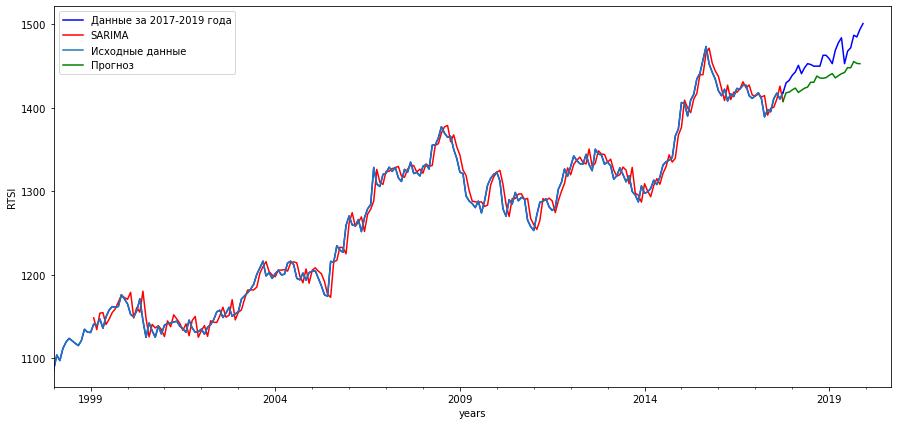

In [16]:

df['model'] = invboxcox(best_model.fittedvalues, lmbda)

df2= df[['id']]
date_list = [datetime.datetime.strptime("2017-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=237, end=262), lmbda)

df3 = pd.read_csv('C:/Users/user/Desktop/VASYA11.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.id.plot(color='blue')
df.model[13:].plot(color='red')
df2.id.plot()
df2.forecast.plot(color='green')
df3.id.plot(color='blue')
plt.legend(['Данные за 2017-2019 года',  'SARIMA', 'Исходные данные', 'Прогноз' ],)
plt.ylabel('RTSI')
plt.xlabel('years')
pylab.show()

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

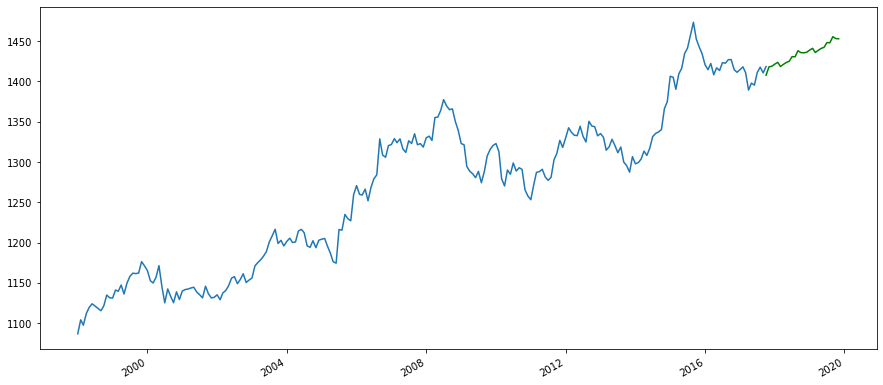

In [17]:
df2.id.plot()
df2.forecast.plot(color='green')

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x504 with 0 Axes>

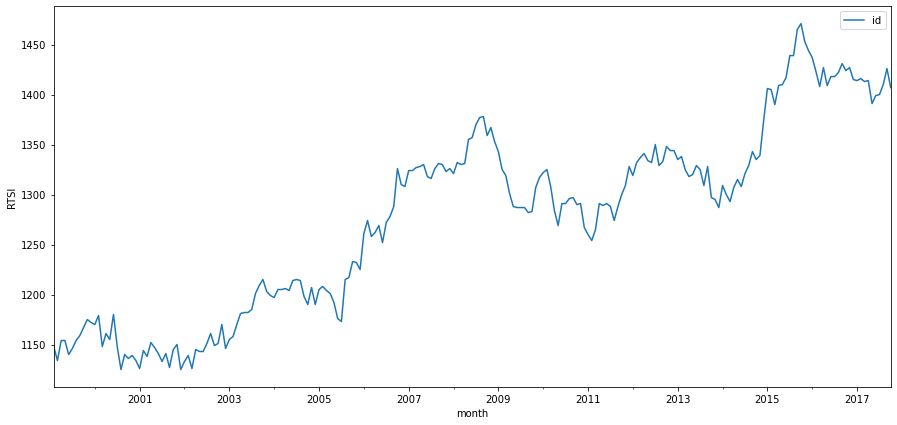

In [18]:
df4 = pd.read_csv('C:/Users/user/Desktop/VASYA61.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
df4.plot()
plt.ylabel('RTSI')
pylab.show()

In [19]:
from sklearn.model_selection import TimeSeriesSplit
#Specify fold and perform splitting
# Указать сгиб и выполнить разделение
tscv = TimeSeriesSplit(n_splits=3)
tscv.split(df4)
#Find out no of observations in train and test sets
# Узнать количество наблюдений в тренировочных и тестовых наборах
i=0
for train, test in tscv.split(df4):
    
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


No of observations under train0=57
No of observations under test0=56
No of observations under train0=113
No of observations under test0=56
No of observations under train0=169
No of observations under test0=56


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [20]:
train1, test1 = df4.iloc[:57, 0], df4.iloc[57:113, 0]
train2, test2 = df4.iloc[:113, 0], df4.iloc[113:169, 0]
train3, test3 = df4.iloc[:169, 0], df4.iloc[169:225, 0]

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
#mse = mean_squared_error(Y_train,y_train_price)
#r_squared = r2_score(Y_train,y_train_price)
#print('Mean_Squared_Error :' ,mse)
#print('r_square_value :',r_squared)


#First fold RMSE
model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
r_squared1 = r2_score(test1, pred1)
#RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)

#Second fold RMSE
model2 = ExponentialSmoothing(train2, seasonal='mul', seasonal_periods=12).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])
r_squared2 = r2_score(test2, pred2)
#RMSE2=round(sqrt(mean_squared_error(test2, pred2)),2)

#Third fold RMSE
model3 = ExponentialSmoothing(train3, seasonal='mul', seasonal_periods=12).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
r_squared3 = r2_score(test3, pred3)
#RMSE3=round(sqrt(mean_squared_error(test3, pred3)),2)

#print ("RMSE1:", RMSE1)
#print ("RMSE2:", RMSE2)
#print ("RMSE3:", RMSE3)
print('r_square_value1 :',r_squared1)
print('r_square_value2 :',r_squared2)
print('r_square_value3 :',r_squared3)

Overall_r_squared=round((r_squared1+r_squared2+r_squared3))
print ("Overall r_squared:", Overall_r_squared)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


r_square_value1 : -0.776154519906523
r_square_value2 : -2.1735606870030724
r_square_value3 : -0.7583716306184256
Overall r_squared: -4


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [22]:
#y_true = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
#y_pred = model1.predict(start=test1.index[0], end=test1.index[-1])
#mean_observed_data = sum(y_true) #/ len(y_true)
#ss_tot = sum([(y - mean_observed_data)**2 for y in y_true])
#ss_res = sum([(y - y_hat)**2 for y, y_hat in zip(y_true, y_pred)])
#div = ss_res/ss_tot
#r2 = 1 - div
#print(r2)
#0.9486081370449679

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score


#df.id.plot(color='blue')
#df.model[13:].plot(color='red')
#df2.id.plot()
#df2.forecast.plot(color='green')


#test = df3.id#.model[13:] 
#sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='W').fit(full_output=False, disp=0)
#pred = df2.forecast

#r2 = r2_score(test, pred)
#print('R^2: %1.2f' % r2)

In [24]:
import sklearn.metrics as metrics

In [25]:
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from sklearn.metrics import mean_squared_error, r2_score
#from math import sqrt
#date_list = [datetime.datetime.strptime("2017-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
#test = df3.id#['model']
#ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
#pred = pd.DataFrame(index=date_list, columns= df2.columns)
#model1.predict(start=test1.index[0], end=test1.index[-1])
#r2 = r2_score(test, pred)
#print('R^2: %1.2f' % r2)


#df['model'] = invboxcox(best_model.fittedvalues, lmbda)

#df2= df[['id']]
#date_list = [datetime.datetime.strptime("2017-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
#future = pd.DataFrame(index=date_list, columns= df2.columns)
#df2 = pd.concat([df2, future])
#df2['forecast'] = invboxcox(best_model.predict(start=237, end=262), lmbda)

#df3 = pd.read_csv('C:/Users/user/Desktop/VASYA11.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#df.id.plot(color='blue')
#df.model[13:].plot(color='red')
#df2.id.plot()
#df2.forecast.plot(color='green')
#df3.id.plot(color='blue')
#plt.legend(['Данные за 2017-2019 года',  'SARIMA', 'Исходные данные', 'Прогноз' ],)
#plt.ylabel('RTSI')
#plt.xlabel('years')
#pylab.show()

In [26]:
df['id'].value_counts()

1427.12    2
1411.41    1
1342.52    1
1266.35    1
1135.20    1
          ..
1176.35    1
1139.93    1
1331.58    1
1200.82    1
1366.38    1
Name: id, Length: 237, dtype: int64

In [27]:
df.isnull().sum()

id                  0
sales_box           0
sales_box_diff     12
sales_box_diff2    13
model               0
dtype: int64

In [151]:
#df70 = df[['id']].copy()
df.dtypes

id                 float64
sales_box          float64
sales_box_diff     float64
sales_box_diff2    float64
dtype: object

In [28]:
df.describe()
#X = np.array(df)
#y = np.array(df2)
#print(X.shape)
#print(Y.shape)

,id,sales_box,sales_box_diff,sales_box_diff2,model
count,238.000000,238.000000,226.000000,225.000000,238.000000
mean,1267.642731,235.428706,2.100107,-0.032497,1266.823973
std,98.031282,13.186876,5.568910,2.158505,134.949002
min,1086.800000,210.741518,-12.685766,-5.907236,1.000000
25%,1171.312500,222.479019,-1.572117,-1.345832,1173.864120
50%,1287.785000,238.273297,1.579478,-0.205875,1288.800639
75%,1332.102500,244.176331,5.843322,1.367599,1332.849337
max,1473.520000,262.656554,17.779647,6.525612,1956.359285


In [29]:
df70 = df[['id']].copy()
df70

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id
month,
1998-01-01,1086.80
1998-02-01,1104.14
1998-03-01,1097.51
1998-04-01,1112.03
1998-05-01,1119.60
...,...
2017-06-01,1395.45
2017-07-01,1411.15
2017-08-01,1417.74


In [30]:
#df10 = df.drop(['sales_box','sales_box_diff','sales_box_diff2','model'], inplace=True)
#df10.head()
print(df70.shape)
print(df.shape)

(238, 1)
(238, 5)


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, random_state = 45)

In [34]:
#df.model
#y = np.array(df70)
Y = np.array(df70['id'])

In [35]:
#df70.drop(['id'], axis=1, inplace=True)
#df70.head()

In [36]:
X = np.array(df70)

In [38]:
#print(r2_score(y_test, best_model.predict(X_test)))
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 45)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
from sklearn.linear_model import LinearRegression
alg = LinearRegression()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [40]:
alg.fit(X_train, Y_train)

LinearRegression()

In [41]:
Y_pred = alg.predict(X_test)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
from sklearn.metrics import r2_score

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
r2_score(Y_test, Y_pred)

1.0